# IMERG Late
 - **@author**: Mario Garcia (mario.garcia@utec.edu.uy)
 - **@date**: 2022-07-25
 - **Url**: https://gpm.nasa.gov/data/imerg


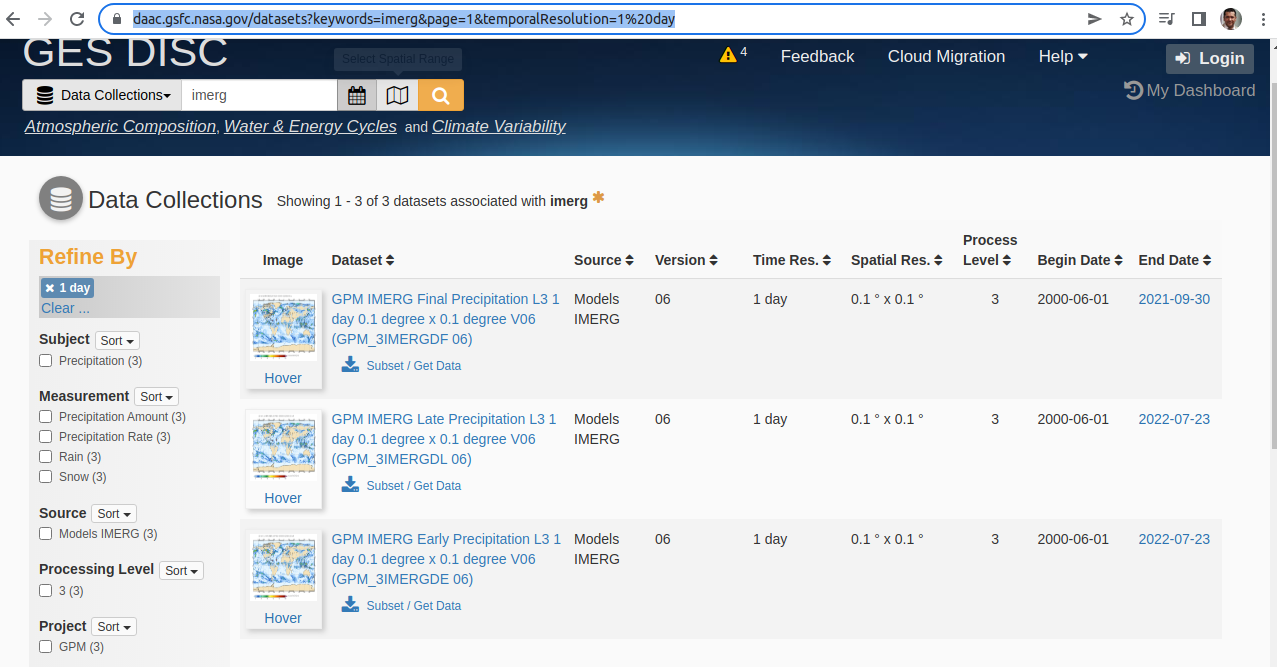

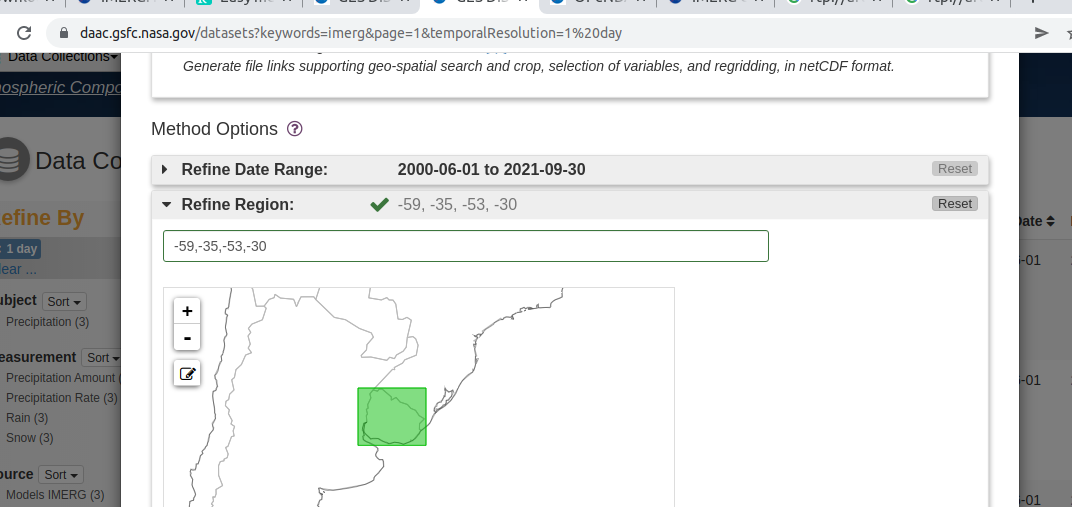

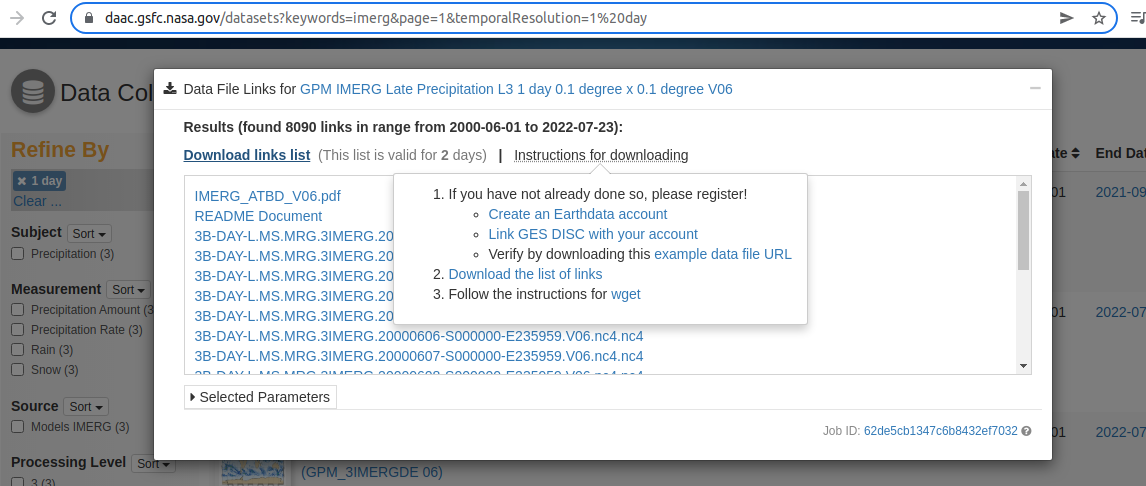

## Request Data



- Url: https://daac.gsfc.nasa.gov/datasets?keywords=imerg&page=1&temporalResolution=1%20day
- Filters:
  - **Temporal Resolution**: day
  - Early Run (optional)
  - Late Run
  - Final Run

## Libraries

In [ ]:
# https://pypi.org/project/wget/
!pip install wget

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=afb8d1831ec67bb08fd6d8de7d205c981157c7f355bff7e239ea8f1ac5735d08
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [ ]:
!pip install geopandas 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 5.1 MB/s 
     |████████████████████████████████| 6.3 MB 47.2 MB/s 
     |████████████████████████████████| 16.7 MB 36.3 MB/s 


In [ ]:
# Data
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

# Utils
import wget
import os 
import shutil
import glob
import requests

# Zip
import zipfile

# NetCDF
import xarray  as xr

# GEO MAPS
# https://jcutrer.com/python/learn-geopandas-plotting-usmaps
import geopandas as gpd
from shapely.geometry import Point, Polygon


In [ ]:
def get_lat_lon(df,lat='lat',lon='lon'):
  char_sep = '#'
  df_ = df.reset_index()[[lat,lon]] #  
  df_['idx'] = df_[lat].astype(str) + char_sep + df_[lon].astype(str)
  df_ = [x.split(char_sep) for x in df_['idx'].unique()]
  df_ = np.array(df_, dtype=np.float64)
  return pd.DataFrame(df_, columns=['lat','lon'])



In [ ]:

def donwload(url, filename):
  result = requests.get(url)
  with open(filename, 'wb') as f:
    f.write(result.content)

## Download Data

Check in your email and copy the download link

In [ ]:
%%bash
cat > /root/.netrc << EOF
machine urs.earthdata.nasa.gov login mariogarcia.ar password **
machine gpm1.gesdisc.eosdis.nasa.gov login mariogarcia.ar password **
EOF


In [ ]:
# !wget "https://acdisc.gesdisc.eosdis.nasa.gov/data//Aqua_AIRS_Level3/AIRX3STD.006/2006/AIRS.2006.12.31.L3.RetStd001.v6.0.9.0.G13155192744.hdf"

In [ ]:
# Download data
shutil.rmtree('./data', ignore_errors=True)
os.mkdir('./data')

!gdown -O ./data/subset_GPM_3IMERGDL_06_20220725_090535 "1Q-NDHVFBlgO82yA-RxxMccU0fAhGU9_O"

ds = pd.read_csv('./data/subset_GPM_3IMERGDL_06_20220725_090535', header = None, sep = '\n')


url=ds[0][3]
filename = "./data/file_01.nc"
donwload(url, filename)


Downloading...
From: https://drive.google.com/uc?id=1Q-NDHVFBlgO82yA-RxxMccU0fAhGU9_O
To: /content/data/subset_GPM_3IMERGDL_06_20220725_090535
100% 1.71M/1.71M [00:00<00:00, 202MB/s]


In [ ]:
filename

'./data/file_01.nc'

In [ ]:
# # unzip data
# with zipfile.ZipFile(filename, 'r') as zip_ref:
#     zip_ref.extractall('data')

## Show Data

In [ ]:
# we're going to use a netCDF file from ./data folder
path = r'./data/*.nc'
files = glob.glob(path)
file=files[0]
print('\n\nFile:', file,'\n\n')

# tips performance
ds_xr = xr.open_dataset(file,chunks={'lat': 100, 'lon': 100,'time': '1GB'})




File: ./data/file_01.nc 




In [ ]:
ds_xr

<xarray.Dataset>
Dimensions:           (time: 1, lon: 61, lat: 51)
Coordinates:
  * lat               (lat) float32 -35.05 -34.95 -34.85 ... -30.15 -30.05
  * lon               (lon) float32 -58.95 -58.85 -58.75 ... -53.05 -52.95
  * time              (time) object 2000-06-02 00:00:00
Data variables:
    precipitationCal  (time, lon, lat) float32 dask.array<chunksize=(1, 61, 51), meta=np.ndarray>
Attributes:
    BeginDate:       2000-06-02
    BeginTime:       00:00:00.000Z
    EndDate:         2000-06-02
    EndTime:         23:59:59.999Z
    FileHeader:      StartGranuleDateTime=2000-06-02T00:00:00.000Z;\nStopGran...
    InputPointer:    3B-HHR-L.MS.MRG.3IMERG.20000602-S000000-E002959.0000.V06...
    title:           GPM IMERG Late Precipitation L3 1 day 0.1 degree x 0.1 d...
    DOI:             10.5067/GPM/IMERGDL/DAY/06
    ProductionTime:  2019-08-07T20:01:18.480Z
    history:         2022-07-25 09:10:23 GMT Hyrax-1.16.3 https://gpm1.gesdis...

In [ ]:
ds_xr.precipitationCal.data

dask.array<open_dataset-930090dddb53beb551278280b396539fprecipitationCal, shape=(1, 61, 51), dtype=float32, chunksize=(1, 61, 51), chunktype=numpy.ndarray>

In [ ]:
import datetime

# ds_xr_query = ds_xr.sel(time= datetime.datetime(2001, 1, 1))
ds_xr_query = ds_xr.where(ds_xr.lat < -30, drop=True)
ds_xr_query = ds_xr_query.where(ds_xr_query.lat > -35, drop=True)

ds_xr_query = ds_xr_query.where(ds_xr_query.lon < -53, drop=True)
ds_xr_query = ds_xr_query.where(ds_xr_query.lon > -59, drop=True)

In [ ]:
# %%time
ds_xr_query_done = ds_xr_query.compute()

In [ ]:
ds_xr_query_done

<xarray.Dataset>
Dimensions:           (time: 1, lon: 60, lat: 50)
Coordinates:
  * lat               (lat) float32 -34.95 -34.85 -34.75 ... -30.15 -30.05
  * lon               (lon) float32 -58.95 -58.85 -58.75 ... -53.15 -53.05
  * time              (time) object 2000-06-02 00:00:00
Data variables:
    precipitationCal  (time, lon, lat) float32 0.0492 0.0 0.2745 ... 0.0 0.0 0.0
Attributes:
    BeginDate:       2000-06-02
    BeginTime:       00:00:00.000Z
    EndDate:         2000-06-02
    EndTime:         23:59:59.999Z
    FileHeader:      StartGranuleDateTime=2000-06-02T00:00:00.000Z;\nStopGran...
    InputPointer:    3B-HHR-L.MS.MRG.3IMERG.20000602-S000000-E002959.0000.V06...
    title:           GPM IMERG Late Precipitation L3 1 day 0.1 degree x 0.1 d...
    DOI:             10.5067/GPM/IMERGDL/DAY/06
    ProductionTime:  2019-08-07T20:01:18.480Z
    history:         2022-07-25 09:10:23 GMT Hyrax-1.16.3 https://gpm1.gesdis...

In [ ]:
df_satellite = ds_xr_query_done.to_dataframe()
df_satellite

precipitationCal
time                lon        lat                         
2000-06-02 00:00:00 -58.950001 -34.950001          0.049199
                               -34.849998          0.000000
                               -34.750000          0.274520
                               -34.650002          0.548519
                               -34.549999          0.502921
...                                                     ...
                    -53.049999 -30.450001          0.000000
                               -30.349998          0.000000
                               -30.250000          0.000000
                               -30.150002          0.000000
                               -30.049999          0.000000

[3000 rows x 1 columns]

In [ ]:
print(df_satellite)

                                           precipitationCal
time                lon        lat                         
2000-06-02 00:00:00 -58.950001 -34.950001          0.049199
                               -34.849998          0.000000
                               -34.750000          0.274520
                               -34.650002          0.548519
                               -34.549999          0.502921
...                                                     ...
                    -53.049999 -30.450001          0.000000
                               -30.349998          0.000000
                               -30.250000          0.000000
                               -30.150002          0.000000
                               -30.049999          0.000000

[3000 rows x 1 columns]


## Visualize ShapeFile

In [ ]:
!gdown -O ./data/Uruguay_shapefile.zip "1ETYRUSliY736y5LmzdMCNZS06A3-FOQT"
!unzip -o -d ./data  ./data/Uruguay_shapefile.zip 


Downloading...
From: https://drive.google.com/uc?id=1ETYRUSliY736y5LmzdMCNZS06A3-FOQT
To: /content/data/Uruguay_shapefile.zip
100% 8.59k/8.59k [00:00<00:00, 10.0MB/s]
Archive:  ./data/Uruguay_shapefile.zip
  inflating: ./data/Uruguay.shp      
  inflating: ./data/Uruguay.dbf      
  inflating: ./data/Uruguay.shx      




File: ./data/Uruguay.shp 




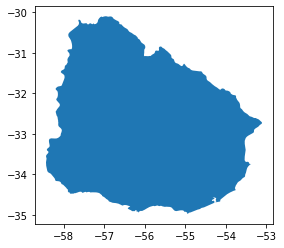

In [ ]:

# # file_shape = "/content/Uruguay.shp"
path = r'./data/*.shp'
files = glob.glob(path)
file_shape=files[0]
print('\n\nFile:', file_shape,'\n\n')


crs={'init':'epsg:4326'}
geodf_shape = gpd.read_file(file_shape, crs=crs)
geodf_shape.plot()


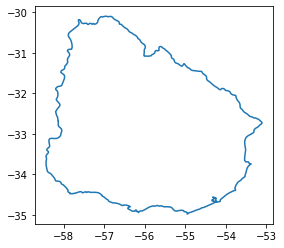

In [ ]:
# plot boundaries
geodf_shape.boundary.plot()

## Plot

In [ ]:
df_sat_lat_lon = get_lat_lon(df_satellite,'lat','lon')
df_sat_lat_lon[:5]

,lat,lon
0,-34.950001,-58.950001
1,-34.849998,-58.950001
2,-34.750000,-58.950001
3,-34.650002,-58.950001
4,-34.549999,-58.950001


In [ ]:
df_sat_lat_lon.describe()

,lat,lon
count,3000.000000,3000.000000
mean,-32.500000,-55.999999
std,1.443328,1.732099
min,-34.950001,-58.950001
25%,-33.750000,-57.475000
50%,-32.500000,-56.000000
75%,-31.250000,-54.525000
max,-30.049999,-53.049999


/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


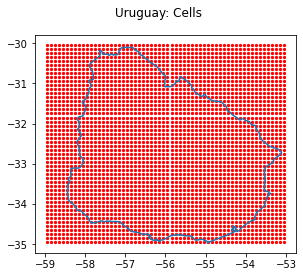

In [ ]:
# coordinate reference system
crs={'init':'epsg:4326'}
geometry=[Point(xy) for xy in zip(df_sat_lat_lon['lon'], df_sat_lat_lon['lat'])]

fig, ax = plt.subplots()

df_geo_cells = gpd.GeoDataFrame(df_sat_lat_lon,crs=crs, geometry=geometry)
df_geo_cells.plot(ax=ax, color='red', markersize=5)

geodf_shape.boundary.plot(ax=ax)

fig.suptitle('Uruguay: Cells ', fontsize=12)
fig.show()

- **Spatial Resolution**: 1°x1°        (157.40 km diagonal distance [111.30kmx111.30km] )
- **Spatial Resolution**: 0.25°x0.25°  (39.35 km diagonal distance [27.83kmx27.83km] ) 
- **Spatial Resolution**: 0.1°x0.1°        (15.74 km diagonal distance [11.13kmx11.13km] )
- **Spatial Resolution**: 0.05°x0.05°  (7.87 km diagonal distance  [5.57kmx5.57km] )

